<a href="https://colab.research.google.com/github/dssp-ethz/DSSP-Illustrations/blob/main/Inversion_of_a_linear_filter_with_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robust Inversion

Let $y[\cdot] = (u * h)[\cdot] + w [\cdot]$ where $h[\cdot]$ is the impulse response of a stable filter and $w[\cdot]$ some disturbance. We wish to reconstruct $u[\cdot]$ with a linear filter, i.e. $\hat{u}[\cdot] = (y * g)[\cdot] = ((u * h) * g)[\cdot] + (w * g) [\cdot]$. Now $g$ should be constructed such that it inverts $h$, but does not amplify the noise $w$. We propose in the frequency domain
$$G(z) = \frac{H^c(z)}{H(z)H^c(z) + \sigma^2}$$
with $\sigma > 0$ a parameter surpressing noise. Frequencies where $H(e^{i\Omega})$ is large are almost ideally reversed ($\sigma \ll |H(e^{i\Omega})|^2$) whereas for frequencies that are removed by the filter $h$ the inversion does not try to reconstruct their content since it likely stems from noise.

In [19]:
pip install pydsm

In [20]:
!gdown https://drive.google.com/uc?id=1-nxgfNaJPeB88X_kE5T2xDqiGI5T2I1u
!gdown https://drive.google.com/uc?id=1937_NrN8dHRPEsAamOn7v6hBSWG1cwzt

Downloading...
From: https://drive.google.com/uc?id=1-nxgfNaJPeB88X_kE5T2xDqiGI5T2I1u
To: /content/signals.py
100% 5.55k/5.55k [00:00<00:00, 9.05MB/s]
Downloading...
From: https://drive.google.com/uc?id=1937_NrN8dHRPEsAamOn7v6hBSWG1cwzt
To: /content/filters.py
100% 1.90k/1.90k [00:00<00:00, 3.46MB/s]


In [21]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pydsm.ft import idtft
import signals
import filters
#-------------------------------------------------------------------------------

sigmaG = 1

logPlotG = False

#Important Stuff
################################################################################

#filter h
def h(t):
  return np.real(idtft(filters.H, t, fs = 2*np.pi)) #sets f_s such that f=Omega

#robust inversion filter G
def G(Omega):
  return np.conjugate(filters.H(Omega))/(np.abs(filters.H(Omega))**2 + sigmaG**2)

#filter g
def g(t):
  return np.real(idtft(G, t, fs = 2*np.pi)) #sets f_s such that f=Omega

#noise
def w(t):
  return np.random.normal(0,0.05,1)[0]

#received signal
def y():
  #convolution in computer is finite. Restrict signals (and filters) to nG to be able to perform computations.
  u_ = signals.time_domain_signal_long()
  h_ = [h(t) for t in signals.nG]
  w_ = [w(t) for t in np.arange(4*signals.nG.size-1)] #result of convolution has dimension (N+M-1) i.e. (nG.size+nG.size-1) = 2*nG.size-1
  r_ = np.convolve(u_,h_) + w_
  delta = len(r_) - len(u_)
  return r_[delta//2: -delta//2]

#estimation
def u_hat():
  #convolution in computer is finite. Restrict signals (and filters) to nG to be able to perform computations.
  y_ = y()
  g_ = [g(t) for t in signals.nG]
  r_ =  np.convolve(y_, g_)
  delta = len(r_) - len(y_)
  return r_[delta//2: -delta//2]
################################################################################

#drawing plots
def plot():
  Omega_values = np.linspace(-np.pi, np.pi, 200)
  H_values = [filters.H(Omega) for Omega in Omega_values]
  G_values = [G(Omega) for Omega in Omega_values]

  fig = plt.figure(figsize=(20, 8))

  ax1 = fig.add_subplot(1, 2, 1)
  ax1.grid()
  ax1.set_xlabel('$\Omega$', fontsize=14)
  ax1.set_ylabel('$H(e^{i\Omega})$', fontsize=14)
  if logPlotG == False:
    ax1.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin=0, ymax=1.5)
    ax1.plot(Omega_values, H_values, alpha=0.5);
  else:
    ax1.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin = 0.1, ymax = 1.5)
    ax1.semilogy(Omega_values, H_values, alpha=0.5);

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.grid()
  ax2.set_xlabel('$\Omega$', fontsize=14)
  ax2.set_ylabel('$G(e^{i\Omega})$', fontsize=14)
  if logPlotG == False:
    ax2.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin=0, ymax=1.5)
    ax2.plot(Omega_values, G_values, alpha=0.5);
  else:
    ax2.axis(xmin=Omega_values[0], xmax=Omega_values[-1], ymin = 0.1, ymax = 1.5)
    ax2.semilogy(Omega_values, G_values, alpha=0.5);

def plot_time():
  t1_values = np.arange(3*np.min(signals.nG), 3*np.max(signals.nG)+3)
  u_values = signals.time_domain_signal_long()
  t2_values = np.arange(3*np.min(signals.nG), 3*np.max(signals.nG)+3)
  y_values = y()
  t3_values = np.arange(3*np.min(signals.nG), 3*np.max(signals.nG)+3)
  u_hat_values = u_hat()


  fig = plt.figure(figsize=(20, 8))

  ax1 = fig.add_subplot(1, 3, 1)
  ax1.grid()
  ax1.set_xlabel('$k$', fontsize=14)
  ax1.set_ylabel('$u[k]$', fontsize=14)
  ax1.axis(xmin=t1_values[0], xmax=t1_values[-1])
  if logPlotG == False:
    ax1.axis(ymin=-3, ymax=3)
    ax1.plot(t1_values, u_values, alpha=0.5, marker='o', markersize=8);
  else:
    ax1.axis(ymin=0.1, ymax=3)
    ax1.semilogy(t1_values, u_values, alpha=0.5, marker='o', markersize=8);

  ax2 = fig.add_subplot(1, 3, 2)
  ax2.grid()
  ax2.set_xlabel('$k$', fontsize=14)
  ax2.set_ylabel('$y[k]$', fontsize=14)
  ax2.axis(xmin=t2_values[0], xmax=t2_values[-1])
  if logPlotG == False:
    ax2.axis(ymin=-3, ymax=3)
    ax2.plot(t2_values, y_values, alpha=0.5, marker='o', markersize=8);
  else:
    ax2.axis(ymin=0.1, ymax=3)
    ax2.semilogy(t2_values, y_values, alpha=0.5, marker='o', markersize=8);

  ax3 = fig.add_subplot(1, 3, 3)
  ax3.grid()
  ax3.set_xlabel('$k$', fontsize=14)
  ax3.set_ylabel('$\hat{u}[k]$', fontsize=14)
  ax3.axis(xmin=t3_values[0], xmax=t3_values[-1])
  if logPlotG == False:
    ax3.axis(ymin=-3, ymax=3)
    ax3.plot(t3_values, u_hat_values, alpha=0.5, marker='o', markersize=8);
  else:
    ax3.axis(ymin=0.1, ymax=3)
    ax3.semilogy(t3_values, u_hat_values, alpha=0.5, marker='o', markersize=8);

In [22]:
signals.widget()
filters.widget()

def update_parameters(sigma, logPlot):
  global sigmaG, logPlotG
  sigmaG, logPlotG = sigma, logPlot

widgets.interact(update_parameters,
  sigma = widgets.FloatSlider(
    value=1,
    min=0.01,
    max=10,
    description='sigma'),
  logPlot = widgets.Checkbox(
    value=False,
    description='logarithmic plot')
);

interactive(children=(Dropdown(description='signal type', options=('unit step', 'unit impulse', 'ramp', 'expon…

interactive(children=(Dropdown(description='filter type', options=('low pass', 'high pass', 'band pass', 'all …

interactive(children=(FloatSlider(value=1.0, description='sigma', max=10.0, min=0.01), Checkbox(value=False, d…

In [23]:
widgets.interact(
      filter = widgets.Dropdown(
        options=['low pass', 'high pass', 'band pass', 'all pass', 'no pass'],
        value='low pass',
        description='filter type'),
      cutoffFrequency = widgets.FloatSlider(
        value=np.pi/2,
        min=0,
        max=np.pi,
        description='cut off')
    );

You may select different signals (adjustable by a parameter) and filter types (along with cut off frequency) for $h$. Sigma allows you to change the robustness of the inversion filter $g$. You should note that the signals are distorted more heavily if the low frequencies are removed in which case it is more important to have a robust inversion filter.

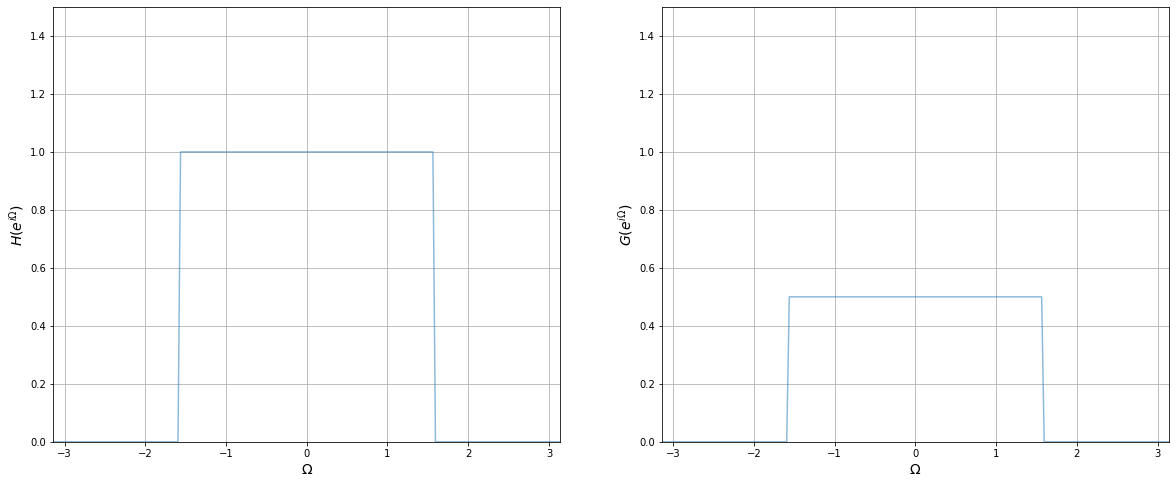

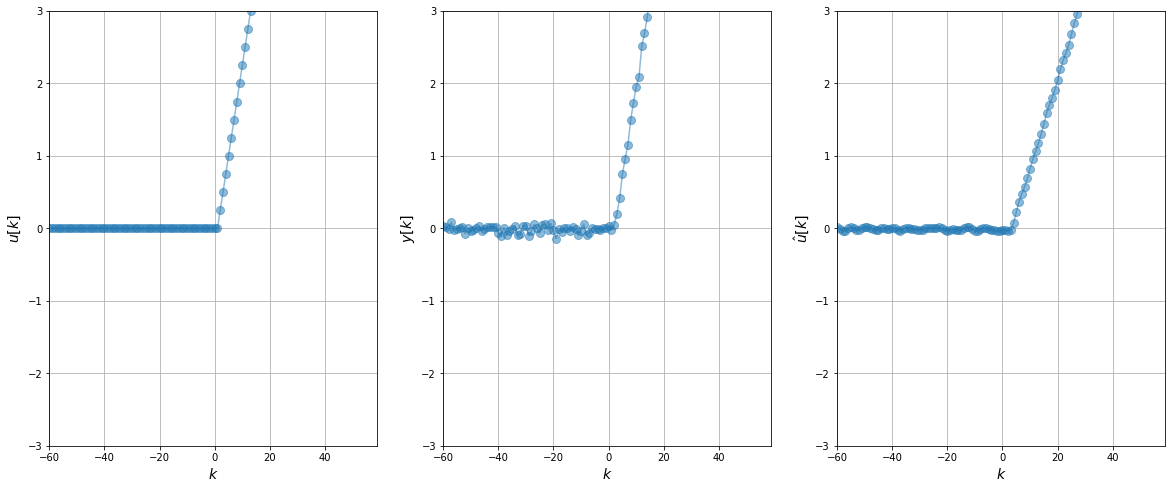

In [25]:
plot()
plot_time()